In [7]:
using DynamicalSystems, DifferentialEquations, OrdinaryDiffEq, StaticArrays

X = u = Y= 0..1
E = 0..20
box = E × X × u × Y

using CairoMakie

In [8]:
τ = 0.013
α = 1.5
J = 3.07
τ_D = 0.15
U0 = 0.35
τ_F = 1
ΔU0 = 0.305
τ_y = 1.8
β = 0.4375
xthr = 0.9
ythr = 0.5

0.5

In [9]:
U(y) = U0 + ΔU0 / ( 1 + exp( -50 * ( y - ythr ) ) )
σ(x)= 1 / (1 + exp(-20 * (x - xthr)))

σ (generic function with 1 method)

In [10]:
function model(u, p ,t)
    
    E, x, u_, y = u
    τ, α, τ_D, J, U0, ΔU0, τ_y, β, xthr, ythr, I0 = p
    
    du1 = (-E + α * log( 1 + exp( ( J * u_ * x * E + I0 ) / α ) )) / τ
    du2 = ( 1 - x ) / τ_D - u_ * x * E
    du3 = (U(y) - u_) / τ_F + U(y) * ( 1 - u_ ) * E
    du4 = -y /  τ_y + β * σ(x)
    
    return SVector(du1, du2, du3, du4)
    
end

model (generic function with 1 method)

In [11]:
p = SA[0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]

u0 = SA[3.3403239669724387, 0.1, 0.1, 0.03677942307955071]
tspan = (0.0, 2500.0)

ds = ContinuousDynamicalSystem(model, u0, p)

println(ds.p)
tr = trajectory(ds, tspan[2], Ttr = tspan[2]; Δt = 0.001, diffeq = (alg = RK4(),  adaptive = false, dt = 0.001))

[0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]


4-dimensional Dataset{Float64} with 2500001 points
 2.95813   0.449264  0.840063  0.0382399
 2.89023   0.451821  0.839737  0.0382187
 2.82405   0.45438   0.839408  0.0381975
 2.75957   0.456942  0.839076  0.0381764
 2.69675   0.459505  0.83874   0.0381552
 2.63557   0.462069  0.838402  0.0381341
 2.576     0.464635  0.838062  0.038113
 2.51801   0.467201  0.837718  0.0380919
 2.46158   0.469768  0.837372  0.0380708
 2.40667   0.472334  0.837024  0.0380498
 2.35325   0.4749    0.836673  0.0380287
 2.30132   0.477465  0.83632   0.0380077
 2.25082   0.480029  0.835964  0.0379867
 ⋮                             
 0.92396   0.722498  0.789135  0.0359006
 0.926075  0.723816  0.788765  0.035893
 0.928241  0.725123  0.788395  0.0358858
 0.930456  0.72642   0.788026  0.0358789
 0.932719  0.727706  0.787657  0.0358723
 0.935031  0.728981  0.787289  0.035866
 0.937389  0.730246  0.786922  0.0358601
 0.939795  0.7315    0.786555  0.0358546
 0.942246  0.732745  0.786189  0.0358494
 0.944743  0.73397

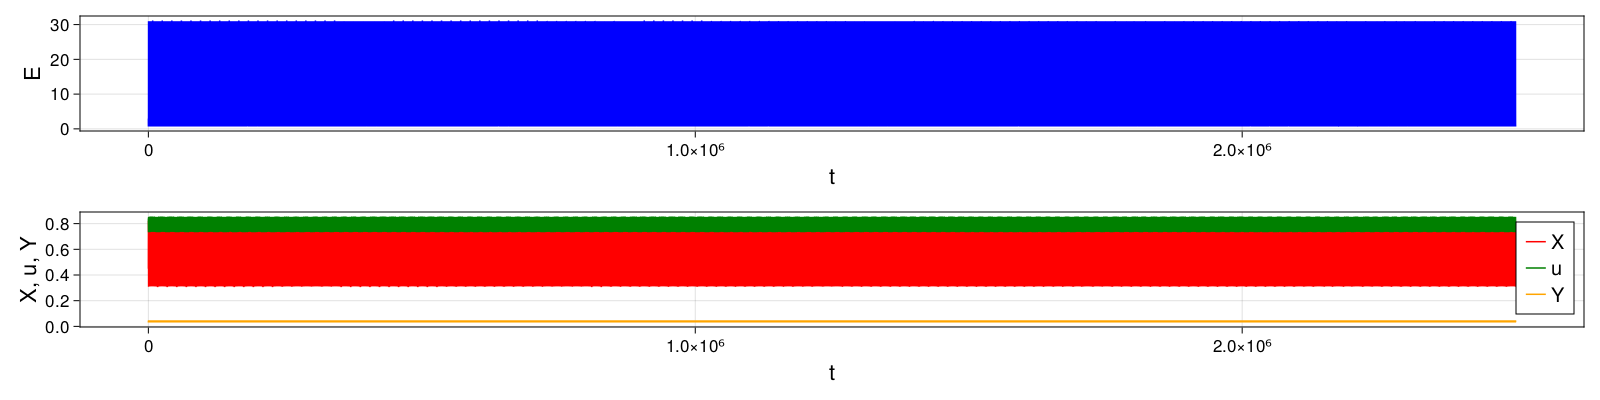

In [22]:
f = Figure(resolution = (1600, 400))

ax1 = Axis(f[1, 1], xlabel = "t", ylabel = "E", xlabelsize = 22, ylabelsize = 22,xticklabelsize = 17, yticklabelsize = 17)
ax2 = Axis(f[2, 1], xlabel = "t", ylabel = "X, u, Y", xlabelsize = 22, ylabelsize = 22,xticklabelsize = 17, yticklabelsize = 17)

ts, tf = 1, 2500000

lines!(ax1, tr[ts:tf, 1], color = "blue", label = "E")

lines!(ax2, tr[ts:tf, 2], color = "red", label = "X")
lines!(ax2, tr[ts:tf, 3], color = "green", label = "u")
lines!(ax2, tr[ts:tf, 4], color = "orange", label = "Y")

axislegend(ax2, labelsize=20)
f

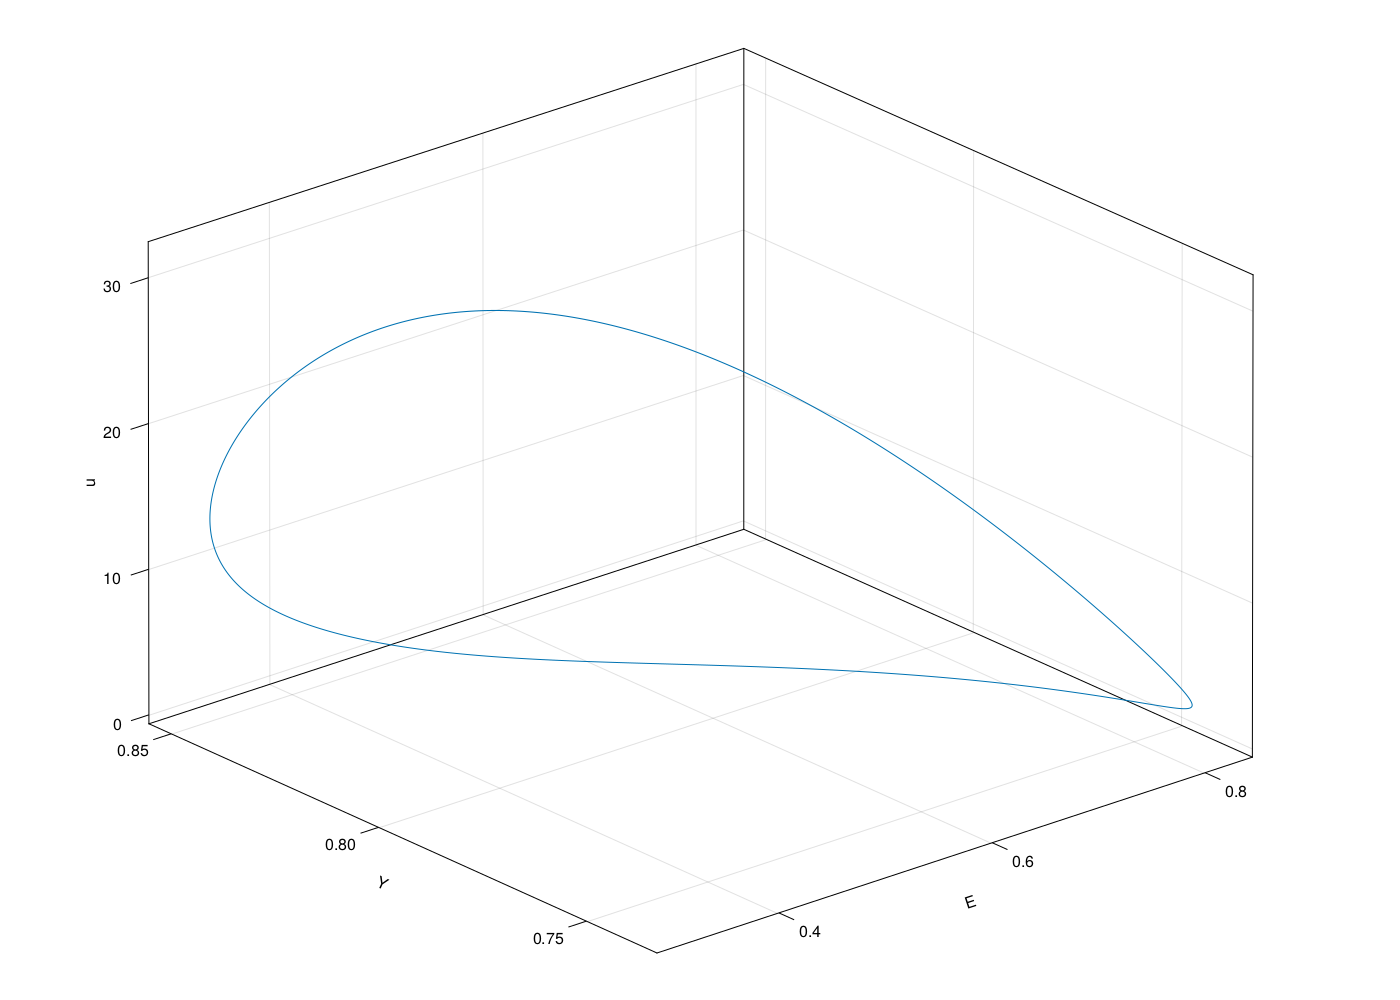

In [21]:
cord1 = 2
cord2 = 3
cord3 = 1
f = Figure(resolution = (1400, 1000))
ts, tf = 1, 100000
ax = Axis3(f[1, 1], xlabel = "E", ylabel = "Y", zlabel = "u")
lines!(tr[ts:tf, cord1], tr[ts:tf, cord2], tr[ts:tf, cord3], linewidth = 1)
#scatter!(fp[1][cord1], fp[1][cord2], fp[1][cord3], color = "red", label = "$fp[1]")
#scatter!(fp[2][cord1], fp[2][cord2], fp[2][cord3], color = "orange", label = "$fp[2]")
#scatter!(fp[3][cord1], fp[3][cord2], fp[3][cord3], color = "lime", label = "$fp[3]")

f

In [14]:
λλ = lyapunovspectrum(ds, tspan[2], Δt = 1, Ttr = tspan[2]/2; diffeq = (alg = RK4(),  adaptive = false, dt = 0.01) )

4-element Vector{Float64}:
  0.00017243189271897997
 -0.5555555563026191
 -2.2773423199424156
 -8.778920399801388

In [15]:
function diff_fp(fp, point)
    
    len = length(fp)
    ϵ = [0.001, 0.001, 0.001, 0.001]
    res = zeros(len)
    for index in range(1, len, step = 1)
        
        if ( abs.(fp[index] - abs.(point)) ) < ϵ
            res[index] = index
        else
            res[index] = -1
            
        end
    end
    return convert(Int64, maximum(res))
    
end

function diff_eigs(λλ, eigs)
    ϵ = [0.01, 0.01, 0.01, 0.01]
    dif = abs.( sort( real(eigs) ) + (-1) * sort( λλ ) )
    if dif < ϵ
        return true # bad
    else
        return false # good
    end
end

diff_eigs (generic function with 1 method)

In [24]:
tspan = (0.0, 2500.0)

(0.0, 2500.0)

In [30]:
U0_start =  0.35
U0_finish = 0
U0_step = -0.02/2

I0_start =  -1.8
I0_finish = -1.1
I0_step = 0.02


range_U0 = range(U0_start, U0_finish, step = U0_step)
range_I0 = range(I0_start, I0_finish, step = I0_step)

-1.8:0.02:-1.1

In [31]:
length(range_I0), length(range_U0)

(36, 36)

In [32]:
length(range_I0) *  length(range_U0)

1296

In [33]:
array_initial_condition = zeros(length(range_U0), length(range_I0), 4 )
array_SLE = zeros(length(range_U0), length(range_I0), 4 )

36×36×4 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 

In [ ]:
for (index_i, U0_lc) in enumerate(range_U0)
    for (index_j, I0_lc) in enumerate(range_I0)
        
        println("index i: $index_i"); flush(stdout)
        println("index j: $index_j"); flush(stdout)
        println("U0: $U0_lc;"); flush(stdout)
        println("I0: $I0_lc;"); flush(stdout)
            
            
        u0_lc = SA[3.3403239669724387, 0.1, 0.1, 0.03677942307955071] # НАЧАЛЬНЫЕ УСЛОВИЯ ДЛЯ 0.35;-1.8 НЕ ТРОГАТЬ
            
        println("u0: $u0_lc")
            
        array_initial_condition[index_i, index_j, :] = u0_lc 
            
        p_lc = SA[τ, α, τ_D, J, U0_lc, ΔU0, τ_y, β, xthr, ythr, I0_lc]
        ds_lc = ContinuousDynamicalSystem(model, u0_lc, p_lc)
            
        tr = trajectory(ds_lc, tspan[2], Ttr = tspan[2]/2; Δt = 0.001,
                                    diffeq = (alg = RK4(),  adaptive = false, dt = 0.01))
        λλ = lyapunovspectrum(ds_lc, tspan[2], Δt = 1, Ttr = tspan[2]/2;
                                    diffeq = (alg = RK4(),  adaptive = false, dt = 0.01) )
        
        fp, eigs, stable = fixedpoints(ds_lc, box)
       
        println(""); flush(stdout)
        println("param: $(ds_lc.p)")
        
        point = tr[end, :]
        index = diff_fp(fp, point)
         println("point: $point")
        if index > 0
            global check_fp = diff_eigs(λλ, eigs[ index ])
            
            if check_fp == true
                array_SLE[index_i, index_j, :] =  [NaN,NaN,NaN,NaN]
            
            
            end
        else
            array_SLE[index_i, index_j, :] =  λλ
        end
            
        
        println("SLE: $(array_SLE[index_i, index_j, :])"); flush(stdout)
        println(""); flush(stdout)

    end
end

index i: 1
index j: 1
U0: 0.35;
I0: -1.8;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]
point: [27.203974414714853, 0.3454133217244405, 0.8267967861126312, 0.040383499270284305]
SLE: [0.00017243189271897997, -0.5555555563026191, -2.2773423199424156, -8.778920399801388]

index i: 1
index j: 2
U0: 0.35;
I0: -1.78;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.78]
point: [1.1642056992529188, 0.7768138362817082, 0.7719230341371701, 0.03054450425693291]
SLE: [0.0009319756481555497, -0.5555555554001581, -2.4272453604304105, -8.304754372161163]

index i: 1
index j: 3
U0: 0.35;
I0: -1.76;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.76]
point: [1.306405898472492, 0.5630360925421948, 0.8259470390070578, 0.02644458987558451]
SLE: [-0.0011074761110779


index i: 1
index j: 27
U0: 0.35;
I0: -1.28;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.28]
point: [10.502269969453668, 0.42438581794407637, 0.8609861914428081, 5.822187092849929e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 1
index j: 28
U0: 0.35;
I0: -1.26;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.26]
point: [10.545208110011451, 0.42326317708571115, 0.8614315606519821, 5.69292857984711e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 1
index j: 29
U0: 0.35;
I0: -1.24;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.35, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.24]
point: [10.58789997192904, 0.42215263297689215, 0.8618715551357485, 5.567886343666063e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 1
index j: 30
U0: 0.35;
I0: -1.22;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5


index i: 2
index j: 17
U0: 0.34;
I0: -1.48;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.34, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.48]
point: [10.057863905967249, 0.43635051789241724, 0.8562027189627347, 7.396078975927057e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 2
index j: 18
U0: 0.34;
I0: -1.46;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.34, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.46]
point: [10.10364716070361, 0.4350880487565164, 0.8567106746922137, 7.211687332693868e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 2
index j: 19
U0: 0.34;
I0: -1.44;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.34, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.44]
point: [10.14910985145179, 0.43384134171156724, 0.8572115351959997, 7.034109244888332e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 2
index j: 20
U0: 0.34;
I0: -1.42;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5,


index i: 3
index j: 8
U0: 0.33;
I0: -1.66;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.33, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.66]
point: [1.376754078487295, 0.7027488856494333, 0.7996795625819679, 0.009688164428156652]
SLE: [8.802180924150013e-5, -0.5555555555950958, -2.9309733271481573, -4.239707426646227]

index i: 3
index j: 9
U0: 0.33;
I0: -1.64;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.33, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.64]
point: [1.4644876945043974, 0.6361252715510267, 0.8169970685210299, 0.007180073014043223]
SLE: [0.0004076920593290689, -0.5555555555461719, -2.5643446616188945, -3.559172836817808]

index i: 3
index j: 10
U0: 0.33;
I0: -1.62;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.33, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.62]
point: [3.443969251994514, 0.4652337545118436, 0.8487646825822417, 0.004427965641164129]
SLE: [-0.0020322499970


index i: 3
index j: 36
U0: 0.33;
I0: -1.1;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.33, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.1]
point: [10.88031340023204, 0.4146945506687397, 0.8648117364438656, 4.796390527782603e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 4
index j: 1
U0: 0.32;
I0: -1.8;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.32, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]
point: [27.203974414714853, 0.3454133217244405, 0.8267967861126312, 0.040383499270284305]
SLE: [0.00017243189271897997, -0.5555555563026191, -2.2773423199424156, -8.778920399801388]

index i: 4
index j: 2
U0: 0.32;
I0: -1.78;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.32, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.78]
point: [1.1642056992529188, 0.7768138362817082, 0.7719230341371701, 0.03054450425693291]
SLE: [0.0009319756481555497, -0.5555555554001581, -2.4272453604304105, -8.304754372161163


index i: 4
index j: 26
U0: 0.32;
I0: -1.3;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.32, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.3]
point: [10.45907944508982, 0.425520856608042, 0.8605353068638979, 5.955856707751733e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 4
index j: 27
U0: 0.32;
I0: -1.28;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.32, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.28]
point: [10.502269969453668, 0.42438581794407637, 0.8609861914428081, 5.822187092849929e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 4
index j: 28
U0: 0.32;
I0: -1.26;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.32, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.26]
point: [10.545208110011451, 0.42326317708571115, 0.8614315606519821, 5.69292857984711e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 4
index j: 29
U0: 0.32;
I0: -1.24;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.


index i: 5
index j: 16
U0: 0.31;
I0: -1.5;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.31, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.5]
point: [10.011750677613573, 0.4376292137144699, 0.8556874488006796, 7.587646583432232e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 5
index j: 17
U0: 0.31;
I0: -1.48;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.31, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.48]
point: [10.057863905967249, 0.43635051789241724, 0.8562027189627347, 7.396078975927057e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 5
index j: 18
U0: 0.31;
I0: -1.46;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.31, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.46]
point: [10.10364716070361, 0.4350880487565164, 0.8567106746922137, 7.211687332693868e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 5
index j: 19
U0: 0.31;
I0: -1.44;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0


index i: 6
index j: 7
U0: 0.3;
I0: -1.68;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.3, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.68]
point: [29.64459237556404, 0.4306265111383806, 0.81785878312694, 0.013742185239446002]
SLE: [0.001352833983600929, -0.5555555553750103, -2.919369286632026, -5.089601773068517]

index i: 6
index j: 8
U0: 0.3;
I0: -1.66;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.3, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.66]
point: [1.376754078487295, 0.7027488856494333, 0.7996795625819679, 0.009688164428156652]
SLE: [8.802180924150013e-5, -0.5555555555950958, -2.9309733271481573, -4.239707426646227]

index i: 6
index j: 9
U0: 0.3;
I0: -1.64;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.3, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.64]
point: [1.4644876945043974, 0.6361252715510267, 0.8169970685210299, 0.007180073014043223]
SLE: [0.0004076920593290689, -0.5


index i: 6
index j: 35
U0: 0.3;
I0: -1.12;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.3, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.12]
point: [10.839192915897147, 0.41572793865747587, 0.8644058609625724, 4.896546445275641e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 6
index j: 36
U0: 0.3;
I0: -1.1;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.3, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.1]
point: [10.88031340023204, 0.4146945506687397, 0.8648117364438656, 4.796390527782603e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 7
index j: 1
U0: 0.29;
I0: -1.8;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.29, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]
point: [27.203974414714853, 0.3454133217244405, 0.8267967861126312, 0.040383499270284305]
SLE: [0.00017243189271897997, -0.5555555563026191, -2.2773423199424156, -8.778920399801388]

index i: 7
index j: 2
U0: 0.29;
I0: -1.78;
u0: [3.3403239669724


index i: 7
index j: 25
U0: 0.29;
I0: -1.32;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.29, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.32]
point: [10.415630181962218, 0.4266686064886463, 0.8600787603584132, 6.094143923382247e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 7
index j: 26
U0: 0.29;
I0: -1.3;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.29, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.3]
point: [10.45907944508982, 0.425520856608042, 0.8605353068638979, 5.955856707751733e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 7
index j: 27
U0: 0.29;
I0: -1.28;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.29, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.28]
point: [10.502269969453668, 0.42438581794407637, 0.8609861914428081, 5.822187092849929e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 7
index j: 28
U0: 0.29;
I0: -1.26;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.


index i: 8
index j: 15
U0: 0.28;
I0: -1.52;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.28, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.52]
point: [9.96529760732269, 0.4389246235325616, 0.8551646340445251, 7.786777809979848e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 8
index j: 16
U0: 0.28;
I0: -1.5;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.28, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.5]
point: [10.011750677613573, 0.4376292137144699, 0.8556874488006796, 7.587646583432232e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 8
index j: 17
U0: 0.28;
I0: -1.48;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.28, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.48]
point: [10.057863905967249, 0.43635051789241724, 0.8562027189627347, 7.396078975927057e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 8
index j: 18
U0: 0.28;
I0: -1.46;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.


index i: 9
index j: 6
U0: 0.27;
I0: -1.7;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.27, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.7]
point: [1.3409851769647556, 0.7437795136960255, 0.7860334567846569, 0.015167919787021497]
SLE: [0.0004246775823867429, -0.5555555555629692, -2.851375288940667, -5.86740947743693]

index i: 9
index j: 7
U0: 0.27;
I0: -1.68;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.27, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.68]
point: [29.64459237556404, 0.4306265111383806, 0.81785878312694, 0.013742185239446002]
SLE: [0.001352833983600929, -0.5555555553750103, -2.919369286632026, -5.089601773068517]

index i: 9
index j: 8
U0: 0.27;
I0: -1.66;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.27, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.66]
point: [1.376754078487295, 0.7027488856494333, 0.7996795625819679, 0.009688164428156652]
SLE: [8.802180924150013e-5, -0


index i: 9
index j: 33
U0: 0.27;
I0: -1.16;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.27, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.16]
point: [10.756318722548905, 0.41782579922529434, 0.8635804092705305, 5.106349148693877e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 9
index j: 34
U0: 0.27;
I0: -1.14;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.27, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.14]
point: [10.797862919027857, 0.4167716111945066, 0.8639954543004453, 4.9998218848057946e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 9
index j: 35
U0: 0.27;
I0: -1.12;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.27, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.12]
point: [10.839192915897147, 0.41572793865747587, 0.8644058609625724, 4.896546445275641e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 9
index j: 36
U0: 0.27;
I0: -1.1;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.


index i: 10
index j: 23
U0: 0.26;
I0: -1.36;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.26, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.36]
point: [10.327928682768006, 0.42900355967361264, 0.8591480636649168, 6.385460835942035e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 10
index j: 24
U0: 0.26;
I0: -1.34;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.26, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.34]
point: [10.37191556086033, 0.42782939406867276, 0.8596163991092766, 6.23726778498281e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 10
index j: 25
U0: 0.26;
I0: -1.32;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.26, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.32]
point: [10.415630181962218, 0.4266686064886463, 0.8600787603584132, 6.094143923382247e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 10
index j: 26
U0: 0.26;
I0: -1.3;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1


index i: 11
index j: 13
U0: 0.25;
I0: -1.56;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.25, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.56]
point: [9.871329980745317, 0.4415676575686344, 0.8540953906437907, 8.20942148253846e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 11
index j: 14
U0: 0.25;
I0: -1.54;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.25, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.54]
point: [9.918494336322052, 0.44023725894722304, 0.8546340328087, 7.993887769063282e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 11
index j: 15
U0: 0.25;
I0: -1.52;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.25, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.52]
point: [9.96529760732269, 0.4389246235325616, 0.8551646340445251, 7.786777809979848e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 11
index j: 16
U0: 0.25;
I0: -1.5;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.1

u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.24, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.74]
point: [1.1818169602436357, 0.5932829118180051, 0.8216582811381712, 0.022088061712127766]
SLE: [0.0015494617873996345, -0.5555555547355631, -2.666263097115777, -7.20180546289615]

index i: 12
index j: 5
U0: 0.24;
I0: -1.72;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.24, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.72]
point: [1.1071989920513878, 0.7106129503113932, 0.796098975881773, 0.01806615293903702]
SLE: [-0.000920234835022033, -0.5555555560846159, -2.7645309010688597, -6.567755403270641]

index i: 12
index j: 6
U0: 0.24;
I0: -1.7;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.24, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.7]
point: [1.3409851769647556, 0.7437795136960255, 0.7860334567846569, 0.015167919787021497]
SLE: [0.0004246775823867429, -0.5555555555629692, -2.851375288940667


index i: 12
index j: 31
U0: 0.24;
I0: -1.2;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.24, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.2]
point: [10.672568111397975, 0.4199666886012877, 0.8627359548602964, 5.3297250281162015e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 12
index j: 32
U0: 0.24;
I0: -1.18;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.24, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.18]
point: [10.714555466963429, 0.4188907422168505, 0.8631606146288834, 5.2162677748532135e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 12
index j: 33
U0: 0.24;
I0: -1.16;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.24, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.16]
point: [10.756318722548905, 0.41782579922529434, 0.8635804092705305, 5.106349148693877e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 12
index j: 34
U0: 0.24;
I0: -1.14;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013,


index i: 13
index j: 21
U0: 0.23;
I0: -1.4;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.23, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.4]
point: [10.23910905872578, 0.4313934605202477, 0.8581927967602102, 6.698058503215312e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 13
index j: 22
U0: 0.23;
I0: -1.38;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.23, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.38]
point: [10.283662352115837, 0.4301914583019252, 0.8586735875359788, 6.538970157105435e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 13
index j: 23
U0: 0.23;
I0: -1.36;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.23, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.36]
point: [10.327928682768006, 0.42900355967361264, 0.8591480636649168, 6.385460835942035e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 13
index j: 24
U0: 0.23;
I0: -1.34;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.


index i: 14
index j: 11
U0: 0.22;
I0: -1.6;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.22, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.6]
point: [9.77587162428381, 0.44428403636760366, 0.8529928973133339, 8.66770640416709e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 14
index j: 12
U0: 0.22;
I0: -1.58;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.22, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.58]
point: [9.823793093787188, 0.44291638489484497, 0.85354843961837, 8.433856597355969e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 14
index j: 13
U0: 0.22;
I0: -1.56;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.22, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.56]
point: [9.871329980745317, 0.4415676575686344, 0.8540953906437907, 8.20942148253846e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 14
index j: 14
U0: 0.22;
I0: -1.54;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.1


index i: 15
index j: 3
U0: 0.21;
I0: -1.76;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.76]
point: [1.306405898472492, 0.5630360925421948, 0.8259470390070578, 0.02644458987558451]
SLE: [-0.001107476111077934, -0.55555555651441, -2.5546546107566255, -7.778729350293534]

index i: 15
index j: 4
U0: 0.21;
I0: -1.74;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.74]
point: [1.1818169602436357, 0.5932829118180051, 0.8216582811381712, 0.022088061712127766]
SLE: [0.0015494617873996345, -0.5555555547355631, -2.666263097115777, -7.20180546289615]

index i: 15
index j: 5
U0: 0.21;
I0: -1.72;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.72]
point: [1.1071989920513878, 0.7106129503113932, 0.796098975881773, 0.01806615293903702]
SLE: [-0.0009202348350220

u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.24]
point: [10.58789997192904, 0.42215263297689215, 0.8618715551357485, 5.567886343666063e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 15
index j: 30
U0: 0.21;
I0: -1.22;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.22]
point: [10.630351424041613, 0.42105389624941536, 0.8623063099493785, 5.4468764318364215e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 15
index j: 31
U0: 0.21;
I0: -1.2;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.2]
point: [10.672568111397975, 0.4199666886012877, 0.8627359548602964, 5.3297250281162015e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 15
index j: 32
U0: 0.21;
I0: -1.18;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.21, 0.305, 1.8, 0.4375, 0.

U0: 0.2;
I0: -1.44;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.2, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.44]
point: [10.14910985145179, 0.43384134171156724, 0.8572115351959997, 7.034109244888332e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 16
index j: 20
U0: 0.2;
I0: -1.42;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.2, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.42]
point: [10.194260958319761, 0.43260995342987824, 0.8577055094324155, 6.863005547258453e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 16
index j: 21
U0: 0.2;
I0: -1.4;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.2, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.4]
point: [10.23910905872578, 0.4313934605202477, 0.8581927967602102, 6.698058503215312e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 16
index j: 22
U0: 0.2;
I0: -1.38;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.2, 0.305, 1.8, 


index i: 17
index j: 10
U0: 0.19;
I0: -1.62;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.19, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.62]
point: [3.443969251994514, 0.4652337545118436, 0.8487646825822417, 0.004427965641164129]
SLE: [-0.002032249997011683, -0.5555555556305869, -1.0437235875100956, -3.487607457999248]

index i: 17
index j: 11
U0: 0.19;
I0: -1.6;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.19, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.6]
point: [9.77587162428381, 0.44428403636760366, 0.8529928973133339, 8.66770640416709e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 17
index j: 12
U0: 0.19;
I0: -1.58;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.19, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.58]
point: [9.823793093787188, 0.44291638489484497, 0.85354843961837, 8.433856597355969e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 17
index j: 13
U0: 0.19;
I0: -1.56;
u0: [3.3403239


index i: 18
index j: 2
U0: 0.18;
I0: -1.78;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.18, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.78]
point: [1.1642056992529188, 0.7768138362817082, 0.7719230341371701, 0.03054450425693291]
SLE: [0.0009319756481555497, -0.5555555554001581, -2.4272453604304105, -8.304754372161163]

index i: 18
index j: 3
U0: 0.18;
I0: -1.76;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.18, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.76]
point: [1.306405898472492, 0.5630360925421948, 0.8259470390070578, 0.02644458987558451]
SLE: [-0.001107476111077934, -0.55555555651441, -2.5546546107566255, -7.778729350293534]

index i: 18
index j: 4
U0: 0.18;
I0: -1.74;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.18, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.74]
point: [1.1818169602436357, 0.5932829118180051, 0.8216582811381712, 0.022088061712127766]
SLE: [0.00154946178739

index j: 28
U0: 0.18;
I0: -1.26;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.18, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.26]
point: [10.545208110011451, 0.42326317708571115, 0.8614315606519821, 5.69292857984711e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 18
index j: 29
U0: 0.18;
I0: -1.24;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.18, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.24]
point: [10.58789997192904, 0.42215263297689215, 0.8618715551357485, 5.567886343666063e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 18
index j: 30
U0: 0.18;
I0: -1.22;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.18, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.22]
point: [10.630351424041613, 0.42105389624941536, 0.8623063099493785, 5.4468764318364215e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 18
index j: 31
U0: 0.18;
I0: -1.2;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3


index i: 19
index j: 18
U0: 0.17;
I0: -1.46;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.17, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.46]
point: [10.10364716070361, 0.4350880487565164, 0.8567106746922137, 7.211687332693868e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 19
index j: 19
U0: 0.17;
I0: -1.44;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.17, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.44]
point: [10.14910985145179, 0.43384134171156724, 0.8572115351959997, 7.034109244888332e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 19
index j: 20
U0: 0.17;
I0: -1.42;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.17, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.42]
point: [10.194260958319761, 0.43260995342987824, 0.8577055094324155, 6.863005547258453e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 19
index j: 21
U0: 0.17;
I0: -1.4;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1


index i: 20
index j: 9
U0: 0.16;
I0: -1.64;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.16, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.64]
point: [1.4644876945043974, 0.6361252715510267, 0.8169970685210299, 0.007180073014043223]
SLE: [0.0004076920593290689, -0.5555555555461719, -2.5643446616188945, -3.559172836817808]

index i: 20
index j: 10
U0: 0.16;
I0: -1.62;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.16, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.62]
point: [3.443969251994514, 0.4652337545118436, 0.8487646825822417, 0.004427965641164129]
SLE: [-0.002032249997011683, -0.5555555556305869, -1.0437235875100956, -3.487607457999248]

index i: 20
index j: 11
U0: 0.16;
I0: -1.6;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.16, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.6]
point: [9.77587162428381, 0.44428403636760366, 0.8529928973133339, 8.66770640416709e-5]
SLE: [NaN, NaN, NaN,


index i: 21
index j: 1
U0: 0.15;
I0: -1.8;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.15, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]
point: [27.203974414714853, 0.3454133217244405, 0.8267967861126312, 0.040383499270284305]
SLE: [0.00017243189271897997, -0.5555555563026191, -2.2773423199424156, -8.778920399801388]

index i: 21
index j: 2
U0: 0.15;
I0: -1.78;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.15, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.78]
point: [1.1642056992529188, 0.7768138362817082, 0.7719230341371701, 0.03054450425693291]
SLE: [0.0009319756481555497, -0.5555555554001581, -2.4272453604304105, -8.304754372161163]

index i: 21
index j: 3
U0: 0.15;
I0: -1.76;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.15, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.76]
point: [1.306405898472492, 0.5630360925421948, 0.8259470390070578, 0.02644458987558451]
SLE: [-0.001107476111


index i: 21
index j: 27
U0: 0.15;
I0: -1.28;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.15, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.28]
point: [10.502269969453668, 0.42438581794407637, 0.8609861914428081, 5.822187092849929e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 21
index j: 28
U0: 0.15;
I0: -1.26;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.15, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.26]
point: [10.545208110011451, 0.42326317708571115, 0.8614315606519821, 5.69292857984711e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 21
index j: 29
U0: 0.15;
I0: -1.24;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.15, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.24]
point: [10.58789997192904, 0.42215263297689215, 0.8618715551357485, 5.567886343666063e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 21
index j: 30
U0: 0.15;
I0: -1.22;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013,


index i: 22
index j: 17
U0: 0.14;
I0: -1.48;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.14, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.48]
point: [10.057863905967249, 0.43635051789241724, 0.8562027189627347, 7.396078975927057e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 22
index j: 18
U0: 0.14;
I0: -1.46;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.14, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.46]
point: [10.10364716070361, 0.4350880487565164, 0.8567106746922137, 7.211687332693868e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 22
index j: 19
U0: 0.14;
I0: -1.44;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.14, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.44]
point: [10.14910985145179, 0.43384134171156724, 0.8572115351959997, 7.034109244888332e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 22
index j: 20
U0: 0.14;
I0: -1.42;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 


index i: 23
index j: 8
U0: 0.13;
I0: -1.66;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.13, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.66]
point: [1.376754078487295, 0.7027488856494333, 0.7996795625819679, 0.009688164428156652]
SLE: [8.802180924150013e-5, -0.5555555555950958, -2.9309733271481573, -4.239707426646227]

index i: 23
index j: 9
U0: 0.13;
I0: -1.64;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.13, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.64]
point: [1.4644876945043974, 0.6361252715510267, 0.8169970685210299, 0.007180073014043223]
SLE: [0.0004076920593290689, -0.5555555555461719, -2.5643446616188945, -3.559172836817808]

index i: 23
index j: 10
U0: 0.13;
I0: -1.62;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.13, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.62]
point: [3.443969251994514, 0.4652337545118436, 0.8487646825822417, 0.004427965641164129]
SLE: [-0.0020322499

u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.13, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.12]
point: [10.839192915897147, 0.41572793865747587, 0.8644058609625724, 4.896546445275641e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 23
index j: 36
U0: 0.13;
I0: -1.1;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.13, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.1]
point: [10.88031340023204, 0.4146945506687397, 0.8648117364438656, 4.796390527782603e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 24
index j: 1
U0: 0.12;
I0: -1.8;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.12, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.8]
point: [27.203974414714853, 0.3454133217244405, 0.8267967861126312, 0.040383499270284305]
SLE: [0.00017243189271897997, -0.5555555563026191, -2.2773423199424156, -8.778920399801388]

index i: 24
index j: 2
U0: 0.12;
I0: -1.78;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

p


index i: 24
index j: 25
U0: 0.12;
I0: -1.32;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.12, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.32]
point: [10.415630181962218, 0.4266686064886463, 0.8600787603584132, 6.094143923382247e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 24
index j: 26
U0: 0.12;
I0: -1.3;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.12, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.3]
point: [10.45907944508982, 0.425520856608042, 0.8605353068638979, 5.955856707751733e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 24
index j: 27
U0: 0.12;
I0: -1.28;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.12, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.28]
point: [10.502269969453668, 0.42438581794407637, 0.8609861914428081, 5.822187092849929e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 24
index j: 28
U0: 0.12;
I0: -1.26;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5


index i: 25
index j: 15
U0: 0.11;
I0: -1.52;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.11, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.52]
point: [9.96529760732269, 0.4389246235325616, 0.8551646340445251, 7.786777809979848e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 25
index j: 16
U0: 0.11;
I0: -1.5;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.11, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.5]
point: [10.011750677613573, 0.4376292137144699, 0.8556874488006796, 7.587646583432232e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 25
index j: 17
U0: 0.11;
I0: -1.48;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.11, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.48]
point: [10.057863905967249, 0.43635051789241724, 0.8562027189627347, 7.396078975927057e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 25
index j: 18
U0: 0.11;
I0: -1.46;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5


index i: 26
index j: 6
U0: 0.1;
I0: -1.7;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.7]
point: [1.3409851769647556, 0.7437795136960255, 0.7860334567846569, 0.015167919787021497]
SLE: [0.0004246775823867429, -0.5555555555629692, -2.851375288940667, -5.86740947743693]

index i: 26
index j: 7
U0: 0.1;
I0: -1.68;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.68]
point: [29.64459237556404, 0.4306265111383806, 0.81785878312694, 0.013742185239446002]
SLE: [0.001352833983600929, -0.5555555553750103, -2.919369286632026, -5.089601773068517]

index i: 26
index j: 8
U0: 0.1;
I0: -1.66;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.66]
point: [1.376754078487295, 0.7027488856494333, 0.7996795625819679, 0.009688164428156652]
SLE: [8.802180924150013e-5, -0.55

U0: 0.1;
I0: -1.16;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.16]
point: [10.756318722548905, 0.41782579922529434, 0.8635804092705305, 5.106349148693877e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 26
index j: 34
U0: 0.1;
I0: -1.14;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.14]
point: [10.797862919027857, 0.4167716111945066, 0.8639954543004453, 4.9998218848057946e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 26
index j: 35
U0: 0.1;
I0: -1.12;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1.8, 0.4375, 0.9, 0.5, -1.12]
point: [10.839192915897147, 0.41572793865747587, 0.8644058609625724, 4.896546445275641e-5]
SLE: [NaN, NaN, NaN, NaN]

index i: 26
index j: 36
U0: 0.1;
I0: -1.1;
u0: [3.3403239669724387, 0.1, 0.1, 0.03677942307955071]

param: [0.013, 1.5, 0.15, 3.07, 0.1, 0.305, 1


index i: 27
index j: 23
U0: 0.09;
I0: -1.36;


In [ ]:
fig, ax, hm = heatmap(range_U0, range_I0, array_SLE[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig